In [ ]:
# ============================================================
# Breast Ultrasound: Gatekeeper + Mask-aware 3-Class Classifier
# Dataset: BUSI (benign, malignant, normal)
# ============================================================
# Remove conflicting builds
!pip uninstall -y scikit-learn umap-learn cuml-cu12 || true

# Install compatible versions
!pip install -U "scikit-learn==1.5.0" "tensorflow==2.19.0" opencv-python tqdm matplotlib tensorflow-hub "ml-dtypes>=0.5.0"

# Verify
import sklearn, tensorflow as tf
print("✅ scikit-learn:", sklearn.__version__)
print("✅ TensorFlow:", tf.__version__)

import os, glob, json, random, warnings
warnings.filterwarnings("ignore")
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import cv2
from tqdm import tqdm
from google.colab import drive, files
import tensorflow_hub as hub

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# -------------------------
# 0) Mount Drive & set paths
# -------------------------
print("⚙️ Mounting Drive...")
drive.mount('/content/drive')
print("✅ Drive mounted.")

DATA_ROOTS = [
  "/content/drive/MyDrive/CSE-51/8Th/Capstone/Alternative data/Breast Ultra Image/Dataset_BUSI_with_GT"
]
OUT_DIR = "/content/drive/MyDrive/Capstone/Breast_Models_API"
os.makedirs(OUT_DIR, exist_ok=True)

IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
CLASSES    = ["normal", "benign", "malignant"]
class_to_idx = {c:i for i,c in enumerate(CLASSES)}
idx_to_class = {i:c for c,i in class_to_idx.items()}

# -------------------------
# 1) Dataset collection
# -------------------------
def is_mask_path(p):
    name = os.path.basename(p).lower()
    return ("mask" in name) or name.endswith("_mask.png") or name.endswith("_gt.png")

def collect_dataset(data_roots):
    paths, labels, mask_paths = [], [], []
    for root in data_roots:
        for cls in CLASSES:
            cdir = os.path.join(root, cls)
            if not os.path.isdir(cdir):
                continue
            imgs = []
            for ext in ("*.png","*.jpg","*.jpeg"):
                imgs += glob.glob(os.path.join(cdir, ext))
            imgs = [p for p in imgs if not is_mask_path(p)]
            for p in imgs:
                stem = os.path.splitext(os.path.basename(p))[0].lower()
                folder = os.path.dirname(p)
                mask = ""
                for ext in ("*.png","*.jpg","*.jpeg"):
                    for m in glob.glob(os.path.join(folder, ext)):
                        if "mask" in m.lower() and stem in m.lower():
                            mask = m
                            break
                paths.append(p)
                labels.append(class_to_idx[cls])
                mask_paths.append(mask)
    return np.array(paths), np.array(labels), np.array(mask_paths)

paths, labels, mask_paths = collect_dataset(DATA_ROOTS)
assert len(paths)>0, "❌ No images found. Check DATA_ROOTS or class folder names!"
print(f"🧾 Total images: {len(paths)} | mask coverage ≈ {np.mean(mask_paths!='')*100:.1f}%")

# -------------------------
# 2) Split dataset
# -------------------------
X_temp, X_test, y_temp, y_test, m_temp, m_test = train_test_split(
    paths, labels, mask_paths, test_size=0.15, stratify=labels, random_state=SEED
)
X_train, X_val, y_train, y_val, m_train, m_val = train_test_split(
    X_temp, y_temp, m_temp, test_size=0.1765, stratify=y_temp, random_state=SEED
)
print(f"Split → train={len(X_train)} | val={len(X_val)} | test={len(X_test)}")

# -------------------------
# 3) Helper functions
# -------------------------
def load_image_bgr(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    return img if img is not None else np.zeros((224,224,3), np.uint8)

def load_mask(mask_path, base_img):
    if mask_path and os.path.exists(mask_path):
        m = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        _, mb = cv2.threshold(m, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        return (mb>0).astype(np.uint8)
    else:
        return np.zeros(base_img.shape[:2], np.uint8)

def roi_from_mask(img_bgr, mask_bin):
    if mask_bin.sum()==0: return img_bgr
    ys, xs = np.where(mask_bin>0)
    y0, y1 = max(ys.min()-10,0), min(ys.max()+10, img_bgr.shape[0]-1)
    x0, x1 = max(xs.min()-10,0), min(xs.max()+10, img_bgr.shape[1]-1)
    return img_bgr[y0:y1+1, x0:x1+1]

def to_tensor(img_bgr, size=IMG_SIZE):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_rgb = cv2.resize(img_rgb, size, interpolation=cv2.INTER_AREA)
    return img_rgb.astype(np.float32)/255.0

# -------------------------
# 4) Dataset generator
# -------------------------
def gen_dataset(X, y, M, training=True):
    idxs = np.arange(len(X))
    if training: np.random.shuffle(idxs)
    for i in idxs:
        img = load_image_bgr(X[i])
        mask = load_mask(M[i], img)
        roi = roi_from_mask(img, mask)
        arr = to_tensor(roi)
        if training:
            if random.random()<0.5: arr = arr[:, ::-1, :]
            if random.random()<0.2: arr = np.clip(arr + np.random.uniform(-0.08,0.08), 0,1)
        yield arr, y[i]

sig = (tf.TensorSpec(shape=(IMG_SIZE[0], IMG_SIZE[1], 3), dtype=tf.float32),
       tf.TensorSpec(shape=(), dtype=tf.int32))

def build_tfds(X, y, M, training):
    ds = tf.data.Dataset.from_generator(lambda: gen_dataset(X,y,M,training), output_signature=sig)
    if training: ds = ds.shuffle(1024)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

ds_train = build_tfds(X_train, y_train, m_train, True)
ds_val   = build_tfds(X_val,   y_val,   m_val,   False)
ds_test  = build_tfds(X_test,  y_test,  m_test,  False)


Found existing installation: scikit-learn 1.4.2
Uninstalling scikit-learn-1.4.2:
  Successfully uninstalled scikit-learn-1.4.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 80.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
hdbscan 0.8.41 requires scikit-learn>=1.6, but you have scikit-learn 1.5.0 which is incompatible.
✅ scikit-learn: 1.5.0
✅ TensorFlow: 2.19.0
⚙️ Mounting Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Drive mounted.
🧾 Total images: 2644 | mask coverage ≈ 45.5%
Split → train=1850 | val=397 | test=397


In [ ]:
# -------------------------
# 5) Model: EfficientNetB3 (Auto-Fallback Safe)
# -------------------------
try:
    from tensorflow.keras.applications import EfficientNetB3
    base = EfficientNetB3(include_top=False, weights="imagenet", input_shape=IMG_SIZE+(3,))
    print("✅ Using native EfficientNetB3 from tf.keras.applications")
except:
    print("⚠️ EfficientNetB3 not found, using TensorFlow Hub version instead.")
    effnet_url = "https://tfhub.dev/google/efficientnet/b3/feature-vector/1"
    base = hub.KerasLayer(effnet_url, input_shape=IMG_SIZE+(3,), trainable=False)

# Build classification head
if isinstance(base, keras.Model):
    x = base.output
else:
    inputs = keras.Input(shape=IMG_SIZE+(3,))
    x = base(inputs)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(len(CLASSES), activation="softmax")(x)

if isinstance(base, keras.Model):
    model = keras.Model(inputs=base.input, outputs=outputs)
else:
    model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

ckpt = os.path.join(OUT_DIR, "busi_effnetb3_best.keras")
callbacks = [
    keras.callbacks.ModelCheckpoint(ckpt, monitor="val_accuracy", save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1)
]

print("🧠 Training (frozen backbone)…")
model.fit(ds_train, validation_data=ds_val, epochs=20, callbacks=callbacks, verbose=1)

# Fine-tune
if hasattr(base, "trainable"):
    base.trainable = True
    for layer in base.layers[:-40]:
        layer.trainable = False

    model.compile(
        optimizer=keras.optimizers.Adam(1e-5),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    print("🧠 Fine-tuning…")
    model.fit(ds_train, validation_data=ds_val, epochs=10, callbacks=callbacks, verbose=1)

best_model = keras.models.load_model(ckpt, custom_objects={"KerasLayer": hub.KerasLayer})
test_loss, test_acc = best_model.evaluate(ds_test, verbose=0)
print(f"✅ Test accuracy: {test_acc:.3f} | loss: {test_loss:.3f}")


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
✅ Using native EfficientNetB3 from tf.keras.applications
🧠 Training (frozen backbone)…
Epoch 1/20
     58/Unknown 3283s 24s/step - accuracy: 0.7458 - loss: 0.5812
Epoch 1: val_accuracy improved from -inf to 0.27204, saving model to /content/drive/MyDrive/Capstone/Breast_Models_API/busi_effnetb3_best.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 3985s 37s/step - accuracy: 0.7470 - loss: 0.5789 - val_accuracy: 0.2720 - val_loss: 3.0955 - learning_rate: 0.0010
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.8890 - loss: 0.3361
Epoch 2: val_accuracy did not improve from 0.27204
58/58 ━━━━━━━━━━━━━━━━━━━━ 49s 476ms/step - accuracy: 0.8890 - loss: 0.3358 - val_accuracy: 0.2720 - val_loss: 19.9778 - learning_rate: 0.0010
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.9321 - loss: 0.2055
Epoch 3: val_accuracy did not improve from 0.27204
58/58 ━━━━━━━━━━━━━━━━━━━━ 49s 473ms/step - accuracy: 0.9320 - loss: 0.2055 - val_a

In [ ]:
# ============================================================
# Recreate and save the model
# ============================================================

# Recreate the model architecture
def build_model(base_model_type):
    if base_model_type == "keras":
        from tensorflow.keras.applications import EfficientNetB3
        # Use input_shape for Keras Applications model
        base = EfficientNetB3(include_top=False, weights=None, input_shape=IMG_SIZE+(3,)) # No weights here
        print("✅ Using native EfficientNetB3 from tf.keras.applications")
        x = base.output
        inputs = base.input # Define inputs from base model
    else: # Use TensorFlow Hub
        effnet_url = "https://tfhub.dev/google/efficientnet/b3/feature-vector/1"
        # Use input_shape for KerasLayer
        base = hub.KerasLayer(effnet_url, input_shape=IMG_SIZE+(3,), trainable=False)
        print("⚠️ EfficientNetB3 not found, using TensorFlow Hub version instead.")
        inputs = keras.Input(shape=IMG_SIZE+(3,))
        x = base(inputs)


    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(len(CLASSES), activation="softmax")(x)

    # Ensure inputs and outputs are correctly defined for the model
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Determine which base model was used during training
try:
    from tensorflow.keras.applications import EfficientNetB3
    # Check if the base model in the original model is from Keras Applications
    # This is a heuristic, a more robust way would be to check the type of `base`
    # in the original model definition if possible. For now, we assume if
    # EfficientNetB3 from keras.applications is available, that's what was used.
    model_type = "keras"
    print("Determined model type: Keras Applications")
    # A more robust check could involve inspecting the layers of the trained model
    # For example: any(isinstance(layer, EfficientNetB3) for layer in best_model.layers)
except:
    model_type = "hub"
    print("Determined model type: TensorFlow Hub")
    # Similarly, check for KerasLayer from hub
    # For example: any(isinstance(layer, hub.KerasLayer) for layer in best_model.layers)


print(f"Attempting to build model with base type: {model_type}")
# Build a new model instance with the determined base type
recreated_model = build_model(model_type)

# Load the best weights from the checkpoint
# Use by_name=True to handle potential layer name differences if model structure is slightly different
try:
    recreated_model.load_weights(ckpt) # Removed by_name=True
    print("✅ Weights loaded into recreated model.")
except Exception as e:
    print(f"❌ Error loading weights: {e}")


# Save the model as a standard TensorFlow SavedModel
export_dir_recreated = os.path.join(OUT_DIR, "api_savedmodel_effnetb3_recreated")
try:
    tf.saved_model.save(recreated_model, export_dir_recreated)
    print("💾 SavedModel exported (recreated model) →", export_dir_recreated)

    # ✅ Save label mapping (for app + API) - This part is already correct
    labels_path = os.path.join(OUT_DIR, "labels_3class.json")
    with open(labels_path, "w") as f:
        json.dump(idx_to_class, f, indent=2)
    print("📝 Labels saved →", labels_path)

    # ✅ Convert SavedModel → TFLite (dynamic-range quantization) - Use the newly saved model
    tflite_path_recreated = os.path.join(OUT_DIR, "busi_effnetb3_recreated.tflite")
    converter_recreated = tf.lite.TFLiteConverter.from_saved_model(export_dir_recreated)
    converter_recreated.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_model_recreated = converter_recreated.convert()

    with open(tflite_path_recreated, "wb") as f:
        f.write(tflite_model_recreated)
    print("📱 TFLite exported (recreated model) →", tflite_path_recreated)

except TypeError as e:
    print(f"❌ Still encountered TypeError during SavedModel export: {e}")
    print("This might be an issue with the TensorFlow version or specific layer compatibility with SavedModel.")
    print("You can still use the loaded 'best_model' for predictions within this notebook.")


# You can still use the best_model loaded previously for testing
# -------------------------
# 7) Multi-image test upload - Keep this part as it uses the loaded best_model
# -------------------------
def preprocess_single_image(img_path, img_size=IMG_SIZE):
    img = cv2.imread(img_path)
    if img is None: return None
    arr = to_tensor(img, img_size)
    return np.expand_dims(arr, axis=0)

def predict_multiple_images(model, img_paths):
    all_probs = []
    for path in img_paths:
        x = preprocess_single_image(path)
        if x is None: continue
        # Use verbose=0 to suppress progress bar for cleaner output
        prob = model.predict(x, verbose=0)[0]
        all_probs.append(prob)
        top = np.argmax(prob)
        print(f"📷 {os.path.basename(path)} → {idx_to_class[top]} ({prob[top]:.2f})")
    if all_probs: # Check if any valid images were processed
      avg = np.mean(all_probs, axis=0)
      return idx_to_class[np.argmax(avg)], float(np.max(avg))
    else:
      return "N/A", 0.0


print("\n🟦 Upload 1–N BUSI images for testing:")
# Ensure the files.upload() is only called once if you run this cell multiple times
if 'uploaded' not in locals(): # Check if uploaded variable exists
    uploaded = files.upload()

if uploaded:
    # Use the 'best_model' which was successfully loaded with custom_objects
    final_label, conf = predict_multiple_images(best_model, list(uploaded.keys()))
    print(f"\n🔍 Final aggregated prediction → {final_label.upper()} (confidence {conf:.2f})")
else:
    print("No files uploaded.")

In [ ]:
import tensorflow as tf
import os, json, tensorflow_hub as hub

# Paths
OUT_DIR = "/content/drive/MyDrive/Capstone/Breast_Models_API"
keras_model_path = os.path.join(OUT_DIR, "busi_effnetb3_best.keras")
export_dir = os.path.join(OUT_DIR, "api_savedmodel_effnetb3_float32")
tflite_path = os.path.join(OUT_DIR, "busi_effnetb3_float32.tflite")

# ✅ 1. Load model (supports TF-Hub layers)
model = tf.keras.models.load_model(
    keras_model_path, custom_objects={"KerasLayer": hub.KerasLayer}
)
print("✅ Model loaded successfully.")

# ✅ 2. Rebuild clean exportable model
inputs = tf.keras.Input(shape=model.input_shape[1:], name="input")
outputs = model(inputs, training=False)
exportable_model = tf.keras.Model(inputs, outputs)
print("🧩 Rebuilt clean model for export.")

# ✅ 3. Export as TensorFlow SavedModel (correct for Keras 3)
exportable_model.export(export_dir)
print("💾 SavedModel exported safely →", export_dir)

# ✅ 4. Convert to TFLite (float32 precision, no quantization)
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

# ✅ 5. Save .tflite file
with open(tflite_path, "wb") as f:
    f.write(tflite_model)
print("📱 Float32 TFLite exported →", tflite_path)

# ✅ 6. Save label mapping
labels_path = os.path.join(OUT_DIR, "labels_3class.json")
idx_to_class = {0: "normal", 1: "benign", 2: "malignant"}
with open(labels_path, "w") as f:
    json.dump(idx_to_class, f, indent=2)
print("📝 Labels saved →", labels_path)


In [ ]:
# ============================================================
# 📊 MODEL PERFORMANCE VISUALIZATION (SAFE VERSION)
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

# 1️⃣ TRAINING CURVES (if available)
try:
    history = model.history.history if hasattr(model, 'history') else None
except NameError:
    history = None  # model not in scope

if history:
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No training history found — skipping curve plots.")

# 2️⃣ CONFUSION MATRIX
y_true, y_pred = [], []
for X_batch, y_batch in ds_test:
    preds = best_model.predict(X_batch, verbose=0)
    y_true.extend(y_batch.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# 3️⃣ CLASSIFICATION REPORT
report = classification_report(y_true, y_pred, target_names=CLASSES, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print("\n📄 Classification Report:")
print(report_df.round(3))

plt.figure(figsize=(8,4))
sns.barplot(x=report_df.index[:-3], y=report_df['f1-score'][:-3])
plt.title("F1-score per Class")
plt.ylabel("F1-Score")
plt.xticks(rotation=30)
plt.show()

# 4️⃣ ROC & AUC Curves for Multi-Class
y_true_bin = tf.keras.utils.to_categorical(y_true, num_classes=len(CLASSES))
y_pred_prob = np.array([
    best_model.predict(X, verbose=0) for X, _ in ds_test
]).reshape(-1, len(CLASSES))

plt.figure(figsize=(7,6))
for i, cls in enumerate(CLASSES):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{cls} (AUC={roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--', lw=1)
plt.title('ROC Curves for Each Class')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# 5️⃣ PRECISION-RECALL Curves
plt.figure(figsize=(7,6))
for i, cls in enumerate(CLASSES):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, lw=2, label=f'{cls}')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()


# Task
Update `scikit-learn` to version `1.5.0` in the first code cell and re-run the cell.

## Update scikit-learn version

### Subtask:
Modify the `pip install` command to use `scikit-learn==1.5.0` instead of `1.4.2` to ensure compatibility with Python 3.12 and resolve the `ValueError` related to `numpy` ufuncs.


## Summary:

### Data Analysis Key Findings
*   The `scikit-learn` library was successfully updated to version `1.5.0` from `1.4.2`.
*   The version verification confirmed `scikit-learn: 1.5.0` and `TensorFlow: 2.19.0` were installed and active.
*   All other specified dependencies, including `tensorflow==2.19.0`, `opencv-python`, `tqdm`, `matplotlib`, `tensorflow-hub`, and `ml-dtypes>=0.5.0`, were correctly installed or confirmed as already satisfied.
*   The remainder of the initial code cell, which involved mounting Google Drive, collecting the dataset, and performing data splits, executed without any errors, indicating a stable environment setup.
*   A warning was observed regarding `hdbscan` requiring `scikit-learn>=1.6`, but this did not prevent the installation of `scikit-learn 1.5.0` as requested.

### Insights or Next Steps
*   The successful update of `scikit-learn` to version `1.5.0` ensures compatibility with Python 3.12 and likely resolves any `ValueError` issues related to `numpy` ufuncs that may have arisen with the older version.
*   Monitor for potential conflicts or issues with packages like `hdbscan` that explicitly require a newer version of `scikit-learn` (`>=1.6`) in subsequent steps of the analysis. If `hdbscan` is critical, a future update strategy for `scikit-learn` (and dependent packages) might be necessary.


## Train and Evaluate Xception

### Subtask:
Define the Xception base model from `tf.keras.applications` and use the `train_and_evaluate_model` function to train and evaluate it on the BUSI dataset.


**Reasoning**:
I need to define a new helper function `build_xception_base_model` to create the Xception base model and then call the `train_and_evaluate_model` with this new builder function to train and evaluate the Xception model.



In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub
import os

# The train_and_evaluate_model function from the previous cell is assumed to be defined.
# Re-defining it here for completeness if this cell is run independently, though it's already in the kernel.

def train_and_evaluate_model(
    base_model_builder,
    model_name,
    ds_train,
    ds_val,
    ds_test,
    CLASSES,
    IMG_SIZE,
    OUT_DIR
):
    """
    Encapsulates the model building, compilation, training, and evaluation process.

    Args:
        base_model_builder: A function that returns a tuple (base_model_instance, input_tensor).
        model_name: A string identifier for the model (e.g., 'EfficientNetB3').
        ds_train, ds_val, ds_test: tf.data.Dataset objects.
        CLASSES: A list of class names.
        IMG_SIZE: A tuple (width, height) for image resizing.
        OUT_DIR: Directory to save model checkpoints.

    Returns:
        Tuple: (best_model, test_accuracy, test_loss).
    """

    def build_classification_head(x, num_classes):
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dropout(0.4)(x)
        outputs = layers.Dense(num_classes, activation="softmax")(x)
        return outputs

    print(f"\n🧠 Building {model_name} model...")
    base, inputs = base_model_builder(IMG_SIZE)

    # Create the full classification model
    if isinstance(base, keras.Model):
        base.trainable = False  # Freeze for initial training
        x = base.output
        outputs = build_classification_head(x, len(CLASSES))
        model = keras.Model(inputs=base.input, outputs=outputs)
        print("✅ Base model from Keras Applications (initially frozen).")
    else: # Assumed to be a tf.hub.KerasLayer
        x = base(inputs)
        outputs = build_classification_head(x, len(CLASSES))
        model = keras.Model(inputs=inputs, outputs=outputs)
        print("✅ Base model from TensorFlow Hub (not explicitly trainable).")

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    # Define callbacks
    ckpt_path = os.path.join(OUT_DIR, f"{model_name}_best.keras")
    callbacks = [
        keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True, verbose=1),
        keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True, verbose=1),
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1)
    ]

    print("\n🧠 Training (frozen backbone)…")
    model.fit(ds_train, validation_data=ds_val, epochs=20, callbacks=callbacks, verbose=1)

    # Fine-tune phase
    if isinstance(base, keras.Model):
        print("\n🧠 Fine-tuning…")
        base.trainable = True
        # Unfreeze a specific number of layers. Adjust as needed.
        # Example: Unfreeze last 40 layers
        for layer in base.layers[:-40]:
            layer.trainable = False

        model.compile(
            optimizer=keras.optimizers.Adam(1e-5),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )

        model.fit(ds_train, validation_data=ds_val, epochs=10, callbacks=callbacks, verbose=1)
    else:
        print("\n⚠️ Skipping fine-tuning for TF Hub KerasLayer (not explicitly trainable in this context).")

    print("\n✨ Loading best model for evaluation...")
    # Load the best model from checkpoint
    best_model = keras.models.load_model(ckpt_path, custom_objects={
        "KerasLayer": hub.KerasLayer if 'hub' in globals() else None
    })
    # Remove the `None` if hub is not defined, should prevent issue.
    if best_model is None:
        # Fallback if custom_objects caused an issue or model failed to load
        best_model = keras.models.load_model(ckpt_path)

    print("\n📊 Evaluating best model on test set...")
    test_loss, test_acc = best_model.evaluate(ds_test, verbose=0)
    print(f"✅ Test accuracy: {test_acc:.3f} | loss: {test_loss:.3f}")

    return best_model, test_acc, test_loss



# Helper function to build the base model for Xception
def build_xception_base_model(img_size):
    from tensorflow.keras.applications import Xception
    base = Xception(include_top=False, weights="imagenet", input_shape=img_size + (3,))
    inputs = base.input
    return base, inputs

# Call the function with the Xception base model builder
print("\n=== Training and Evaluating Xception Model ===")
xception_best_model, xception_test_accuracy, xception_test_loss = train_and_evaluate_model(
    base_model_builder=build_xception_base_model,
    model_name="xception",
    ds_train=ds_train,
    ds_val=ds_val,
    ds_test=ds_test,
    CLASSES=CLASSES,
    IMG_SIZE=IMG_SIZE,
    OUT_DIR=OUT_DIR
)

print(f"\nFinal Xception Best Model Test Accuracy: {xception_test_accuracy:.3f}")
print(f"Final Xception Best Model Test Loss: {xception_test_loss:.3f}")


=== Training and Evaluating Xception Model ===

🧠 Building xception model...
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
✅ Base model from Keras Applications (initially frozen).

🧠 Training (frozen backbone)…
Epoch 1/20
     58/Unknown 91s 720ms/step - accuracy: 0.5889 - loss: 0.8503
Epoch 1: val_accuracy improved from -inf to 0.81108, saving model to /content/drive/MyDrive/Capstone/Breast_Models_API/xception_best.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.5905 - loss: 0.8483 - val_accuracy: 0.8111 - val_loss: 0.5529 - learning_rate: 0.0010
Epoch 2/20
56/58 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.7869 - loss: 0.5809
Epoch 2: val_accuracy improved from 0.81108 to 0.83627, saving model to /content/drive/MyDrive/Capstone/Breast_Models_API/xception_best.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 48s 463ms/step - accuracy: 0.7879 - loss: 0.5792 - val_accuracy: 0.8363 - val_loss: 0.4814 - learning_rate: 0.0010
Epoch 3/20
56/58 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accu

## Train and Evaluate InceptionV3

### Subtask:
Define the InceptionV3 base model from `tf.keras.applications` and use the `train_and_evaluate_model` function to train and evaluate it on the BUSI dataset.


**Reasoning**:
I need to define a new helper function `build_inceptionv3_base_model` to create the InceptionV3 base model and then call the `train_and_evaluate_model` with this new builder function to train and evaluate the InceptionV3 model.



In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub
import os

# The train_and_evaluate_model function from previous cells is assumed to be defined.
# Re-defining it here for completeness if this cell is run independently, though it's already in the kernel.

def train_and_evaluate_model(
    base_model_builder,
    model_name,
    ds_train,
    ds_val,
    ds_test,
    CLASSES,
    IMG_SIZE,
    OUT_DIR
):
    """
    Encapsulates the model building, compilation, training, and evaluation process.

    Args:
        base_model_builder: A function that returns a tuple (base_model_instance, input_tensor).
        model_name: A string identifier for the model (e.g., 'EfficientNetB3').
        ds_train, ds_val, ds_test: tf.data.Dataset objects.
        CLASSES: A list of class names.
        IMG_SIZE: A tuple (width, height) for image resizing.
        OUT_DIR: Directory to save model checkpoints.

    Returns:
        Tuple: (best_model, test_accuracy, test_loss).
    """

    def build_classification_head(x, num_classes):
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dropout(0.4)(x)
        outputs = layers.Dense(num_classes, activation="softmax")(x)
        return outputs

    print(f"\n  Building {model_name} model...")
    base, inputs = base_model_builder(IMG_SIZE)

    # Create the full classification model
    if isinstance(base, keras.Model):
        base.trainable = False  # Freeze for initial training
        x = base.output
        outputs = build_classification_head(x, len(CLASSES))
        model = keras.Model(inputs=base.input, outputs=outputs)
        print("✅ Base model from Keras Applications (initially frozen).")
    else: # Assumed to be a tf.hub.KerasLayer
        x = base(inputs)
        outputs = build_classification_head(x, len(CLASSES))
        model = keras.Model(inputs=inputs, outputs=outputs)
        print("✅ Base model from TensorFlow Hub (not explicitly trainable).")

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    # Define callbacks
    ckpt_path = os.path.join(OUT_DIR, f"{model_name}_best.keras")
    callbacks = [
        keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True, verbose=1),
        keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True, verbose=1),
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1)
    ]

    print("\n  Training (frozen backbone)…")
    model.fit(ds_train, validation_data=ds_val, epochs=20, callbacks=callbacks, verbose=1)

    # Fine-tune phase
    if isinstance(base, keras.Model):
        print("\n  Fine-tuning…")
        base.trainable = True
        # Unfreeze a specific number of layers. Adjust as needed.
        # Example: Unfreeze last 40 layers
        for layer in base.layers[:-40]:
            layer.trainable = False

        model.compile(
            optimizer=keras.optimizers.Adam(1e-5),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )

        model.fit(ds_train, validation_data=ds_val, epochs=10, callbacks=callbacks, verbose=1)
    else:
        print("\n⚠️ Skipping fine-tuning for TF Hub KerasLayer (not explicitly trainable in this context).")

    print("\n✨ Loading best model for evaluation...")
    # Load the best model from checkpoint
    best_model = keras.models.load_model(ckpt_path, custom_objects={
        "KerasLayer": hub.KerasLayer if 'hub' in globals() else None
    })
    # Remove the `None` if hub is not defined, should prevent issue.
    if best_model is None:
        # Fallback if custom_objects caused an issue or model failed to load
        best_model = keras.models.load_model(ckpt_path)

    print("\n  Evaluating best model on test set...")
    test_loss, test_acc = best_model.evaluate(ds_test, verbose=0)
    print(f"✅ Test accuracy: {test_acc:.3f} | loss: {test_loss:.3f}")

    return best_model, test_acc, test_loss


# Helper function to build the base model for InceptionV3
def build_inceptionv3_base_model(img_size):
    from tensorflow.keras.applications import InceptionV3
    base = InceptionV3(include_top=False, weights="imagenet", input_shape=img_size + (3,))
    inputs = base.input
    return base, inputs

# Call the function with the InceptionV3 base model builder
print("\n=== Training and Evaluating InceptionV3 Model ===")
inceptionv3_best_model, inceptionv3_test_accuracy, inceptionv3_test_loss = train_and_evaluate_model(
    base_model_builder=build_inceptionv3_base_model,
    model_name="inceptionv3",
    ds_train=ds_train,
    ds_val=ds_val,
    ds_test=ds_test,
    CLASSES=CLASSES,
    IMG_SIZE=IMG_SIZE,
    OUT_DIR=OUT_DIR
)

print(f"\nFinal InceptionV3 Best Model Test Accuracy: {inceptionv3_test_accuracy:.3f}")
print(f"Final InceptionV3 Best Model Test Loss: {inceptionv3_test_loss:.3f}")


=== Training and Evaluating InceptionV3 Model ===

  Building inceptionv3 model...
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
✅ Base model from Keras Applications (initially frozen).

  Training (frozen backbone)…
Epoch 1/20
     58/Unknown 64s 445ms/step - accuracy: 0.5472 - loss: 1.0736
Epoch 1: val_accuracy improved from -inf to 0.76071, saving model to /content/drive/MyDrive/Capstone/Breast_Models_API/inceptionv3_best.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 86s 845ms/step - accuracy: 0.5488 - loss: 1.0698 - val_accuracy: 0.7607 - val_loss: 0.6025 - learning_rate: 0.0010
Epoch 2/20
56/58 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.7475 - loss: 0.6409
Epoch 2: val_accuracy improved from 0.76071 to 0.81612, saving model to /content/drive/MyDrive/Capstone/Breast_Models_API/inceptionv3_best.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 48s 476ms/step - accuracy: 0.7489 - loss: 0.6378 - val_accuracy: 0.8161 - val_loss: 0.4632 - learning_rate: 0.0010
Epoch 3/20
56/58 ━━━━━━━━━━━━━━━━━━━━ 0s 308

## Train and Evaluate ResNet50

### Subtask:
Define the ResNet50 base model from `tf.keras.applications` and use the `train_and_evaluate_model` function to train and evaluate it on the BUSI dataset.


**Reasoning**:
I need to define a new helper function `build_resnet50_base_model` to create the ResNet50 base model and then call the `train_and_evaluate_model` with this new builder function to train and evaluate the ResNet50 model.

**Reasoning**:
I will define the `build_resnet50_base_model` helper function and then use the `train_and_evaluate_model` function to train and evaluate the ResNet50 model on the BUSI dataset, printing the final accuracy and loss.



In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub
import os

# The train_and_evaluate_model function from previous cells is assumed to be defined.
# Re-defining it here for completeness if this cell is run independently, though it's already in the kernel.

def train_and_evaluate_model(
    base_model_builder,
    model_name,
    ds_train,
    ds_val,
    ds_test,
    CLASSES,
    IMG_SIZE,
    OUT_DIR
):
    """
    Encapsulates the model building, compilation, training, and evaluation process.

    Args:
        base_model_builder: A function that returns a tuple (base_model_instance, input_tensor).
        model_name: A string identifier for the model (e.g., 'EfficientNetB3').
        ds_train, ds_val, ds_test: tf.data.Dataset objects.
        CLASSES: A list of class names.
        IMG_SIZE: A tuple (width, height) for image resizing.
        OUT_DIR: Directory to save model checkpoints.

    Returns:
        Tuple: (best_model, test_accuracy, test_loss).
    """

    def build_classification_head(x, num_classes):
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dropout(0.4)(x)
        outputs = layers.Dense(num_classes, activation="softmax")(x)
        return outputs

    print(f"\n  Building {model_name} model...")
    base, inputs = base_model_builder(IMG_SIZE)

    # Create the full classification model
    if isinstance(base, keras.Model):
        base.trainable = False  # Freeze for initial training
        x = base.output
        outputs = build_classification_head(x, len(CLASSES))
        model = keras.Model(inputs=base.input, outputs=outputs)
        print("✅ Base model from Keras Applications (initially frozen).")
    else: # Assumed to be a tf.hub.KerasLayer
        x = base(inputs)
        outputs = build_classification_head(x, len(CLASSES))
        model = keras.Model(inputs=inputs, outputs=outputs)
        print("✅ Base model from TensorFlow Hub (not explicitly trainable).")

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    # Define callbacks
    ckpt_path = os.path.join(OUT_DIR, f"{model_name}_best.keras")
    callbacks = [
        keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True, verbose=1),
        keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True, verbose=1),
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1)
    ]

    print("\n  Training (frozen backbone)…")
    model.fit(ds_train, validation_data=ds_val, epochs=20, callbacks=callbacks, verbose=1)

    # Fine-tune phase
    if isinstance(base, keras.Model):
        print("\n  Fine-tuning…")
        base.trainable = True
        # Unfreeze a specific number of layers. Adjust as needed.
        # Example: Unfreeze last 40 layers
        for layer in base.layers[:-40]:
            layer.trainable = False

        model.compile(
            optimizer=keras.optimizers.Adam(1e-5),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )

        model.fit(ds_train, validation_data=ds_val, epochs=10, callbacks=callbacks, verbose=1)
    else:
        print("\n⚠️ Skipping fine-tuning for TF Hub KerasLayer (not explicitly trainable in this context).")

    print("\n✨ Loading best model for evaluation...")
    # Load the best model from checkpoint
    best_model = keras.models.load_model(ckpt_path, custom_objects={
        "KerasLayer": hub.KerasLayer if 'hub' in globals() else None
    })
    # Remove the `None` if hub is not defined, should prevent issue.
    if best_model is None:
        # Fallback if custom_objects caused an issue or model failed to load
        best_model = keras.models.load_model(ckpt_path)

    print("\n  Evaluating best model on test set...")
    test_loss, test_acc = best_model.evaluate(ds_test, verbose=0)
    print(f"✅ Test accuracy: {test_acc:.3f} | loss: {test_loss:.3f}")

    return best_model, test_acc, test_loss

# Helper function to build the base model for ResNet50
def build_resnet50_base_model(img_size):
    from tensorflow.keras.applications import ResNet50
    base = ResNet50(include_top=False, weights="imagenet", input_shape=img_size + (3,))
    inputs = base.input
    return base, inputs

# Call the function with the ResNet50 base model builder
print("\n=== Training and Evaluating ResNet50 Model ===")
resnet50_best_model, resnet50_test_accuracy, resnet50_test_loss = train_and_evaluate_model(
    base_model_builder=build_resnet50_base_model,
    model_name="resnet50",
    ds_train=ds_train,
    ds_val=ds_val,
    ds_test=ds_test,
    CLASSES=CLASSES,
    IMG_SIZE=IMG_SIZE,
    OUT_DIR=OUT_DIR
)

print(f"\nFinal ResNet50 Best Model Test Accuracy: {resnet50_test_accuracy:.3f}")
print(f"Final ResNet50 Best Model Test Loss: {resnet50_test_loss:.3f}")



=== Training and Evaluating ResNet50 Model ===

  Building resnet50 model...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
✅ Base model from Keras Applications (initially frozen).

  Training (frozen backbone)…
Epoch 1/20
     58/Unknown 56s 383ms/step - accuracy: 0.4220 - loss: 1.2235
Epoch 1: val_accuracy improved from -inf to 0.53149, saving model to /content/drive/MyDrive/Capstone/Breast_Models_API/resnet50_best.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 74s 690ms/step - accuracy: 0.4229 - loss: 1.2217 - val_accuracy: 0.5315 - val_loss: 0.9851 - learning_rate: 0.0010
Epoch 2/20
56/58 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.4870 - loss: 1.0180
Epoch 2: val_accuracy did not improve from 0.53149
58/58 ━━━━━━━━━━━━━━━━━━━━ 49s 459ms/step - accuracy: 0.4876 - loss: 1.0174 - val_accuracy: 0.5315 - val_loss: 0.9547 - learning_rate: 0.0010
Epoch 3/20
56/58 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.5277 - loss: 0.9725
Epoch 3: val_accuracy did not improve from 0.53149
58/58 ━━━━

## Train and Evaluate VGG16

### Subtask:
Define the VGG16 base model from `tf.keras.applications` and use the `train_and_evaluate_model` function to train and evaluate it on the BUSI dataset.


### Subtask:
Define the VGG16 base model from `tf.keras.applications` and use the `train_and_evaluate_model` function to train and evaluate it on the BUSI dataset.

#### Instructions
1. Define a new helper function `build_vgg16_base_model` that takes `img_size` as an argument.
2. Inside `build_vgg16_base_model`, import the `VGG16` class from `tensorflow.keras.applications`.
3. Instantiate the `VGG16` model, setting `include_top=False`, `weights='imagenet'`, and `input_shape=img_size + (3,)`. Store this in a variable named `base`.
4. Define `inputs` as `base.input`.
5. Return `base` and `inputs` from the `build_vgg16_base_model` function.
6. Call the `train_and_evaluate_model` function with `base_model_builder=build_vgg16_base_model` and `model_name="vgg16"`.
7. Store the returned best model, test accuracy, and test loss in appropriate variables (e.g., `vgg16_best_model`, `vgg16_test_accuracy`, `vgg16_test_loss`).
8. Print the final test accuracy and test loss for the VGG16 model.

**Reasoning**:
I will define the `build_vgg16_base_model` helper function and then use the `train_and_evaluate_model` function to train and evaluate the VGG16 model on the BUSI dataset, printing the final accuracy and loss.



In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub
import os

# The train_and_evaluate_model function from previous cells is assumed to be defined.
# Re-defining it here for completeness if this cell is run independently, though it's already in the kernel.

def train_and_evaluate_model(
    base_model_builder,
    model_name,
    ds_train,
    ds_val,
    ds_test,
    CLASSES,
    IMG_SIZE,
    OUT_DIR
):
    """
    Encapsulates the model building, compilation, training, and evaluation process.

    Args:
        base_model_builder: A function that returns a tuple (base_model_instance, input_tensor).
        model_name: A string identifier for the model (e.g., 'EfficientNetB3').
        ds_train, ds_val, ds_test: tf.data.Dataset objects.
        CLASSES: A list of class names.
        IMG_SIZE: A tuple (width, height) for image resizing.
        OUT_DIR: Directory to save model checkpoints.

    Returns:
        Tuple: (best_model, test_accuracy, test_loss).
    """

    def build_classification_head(x, num_classes):
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dropout(0.4)(x)
        outputs = layers.Dense(num_classes, activation="softmax")(x)
        return outputs

    print(f"\n  Building {model_name} model...")
    base, inputs = base_model_builder(IMG_SIZE)

    # Create the full classification model
    if isinstance(base, keras.Model):
        base.trainable = False  # Freeze for initial training
        x = base.output
        outputs = build_classification_head(x, len(CLASSES))
        model = keras.Model(inputs=base.input, outputs=outputs)
        print("✅ Base model from Keras Applications (initially frozen).")
    else: # Assumed to be a tf.hub.KerasLayer
        x = base(inputs)
        outputs = build_classification_head(x, len(CLASSES))
        model = keras.Model(inputs=inputs, outputs=outputs)
        print("✅ Base model from TensorFlow Hub (not explicitly trainable).")

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    # Define callbacks
    ckpt_path = os.path.join(OUT_DIR, f"{model_name}_best.keras")
    callbacks = [
        keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True, verbose=1),
        keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True, verbose=1),
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1)
    ]

    print("\n  Training (frozen backbone)…")
    model.fit(ds_train, validation_data=ds_val, epochs=20, callbacks=callbacks, verbose=1)

    # Fine-tune phase
    if isinstance(base, keras.Model):
        print("\n  Fine-tuning…")
        base.trainable = True
        # Unfreeze a specific number of layers. Adjust as needed.
        # Example: Unfreeze last 40 layers
        for layer in base.layers[:-40]:
            layer.trainable = False

        model.compile(
            optimizer=keras.optimizers.Adam(1e-5),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )

        model.fit(ds_train, validation_data=ds_val, epochs=10, callbacks=callbacks, verbose=1)
    else:
        print("\n⚠️ Skipping fine-tuning for TF Hub KerasLayer (not explicitly trainable in this context).")

    print("\n✨ Loading best model for evaluation...")
    # Load the best model from checkpoint
    best_model = keras.models.load_model(ckpt_path, custom_objects={
        "KerasLayer": hub.KerasLayer if 'hub' in globals() else None
    })
    # Remove the `None` if hub is not defined, should prevent issue.
    if best_model is None:
        # Fallback if custom_objects caused an issue or model failed to load
        best_model = keras.models.load_model(ckpt_path)

    print("\n  Evaluating best model on test set...")
    test_loss, test_acc = best_model.evaluate(ds_test, verbose=0)
    print(f"✅ Test accuracy: {test_acc:.3f} | loss: {test_loss:.3f}")

    return best_model, test_acc, test_loss

# Helper function to build the base model for VGG16
def build_vgg16_base_model(img_size):
    from tensorflow.keras.applications import VGG16
    base = VGG16(include_top=False, weights="imagenet", input_shape=img_size + (3,))
    inputs = base.input
    return base, inputs

# Call the function with the VGG16 base model builder
print("\n=== Training and Evaluating VGG16 Model ===")
vgg16_best_model, vgg16_test_accuracy, vgg16_test_loss = train_and_evaluate_model(
    base_model_builder=build_vgg16_base_model,
    model_name="vgg16",
    ds_train=ds_train,
    ds_val=ds_val,
    ds_test=ds_test,
    CLASSES=CLASSES,
    IMG_SIZE=IMG_SIZE,
    OUT_DIR=OUT_DIR
)

print(f"\nFinal VGG16 Best Model Test Accuracy: {vgg16_test_accuracy:.3f}")
print(f"Final VGG16 Best Model Test Loss: {vgg16_test_loss:.3f}")



=== Training and Evaluating VGG16 Model ===

  Building vgg16 model...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
✅ Base model from Keras Applications (initially frozen).

  Training (frozen backbone)…
Epoch 1/20
     58/Unknown 48s 372ms/step - accuracy: 0.3020 - loss: 1.4928
Epoch 1: val_accuracy improved from -inf to 0.53149, saving model to /content/drive/MyDrive/Capstone/Breast_Models_API/vgg16_best.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 62s 616ms/step - accuracy: 0.3036 - loss: 1.4883 - val_accuracy: 0.5315 - val_loss: 0.9495 - learning_rate: 0.0010
Epoch 2/20
56/58 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.5272 - loss: 0.9996
Epoch 2: val_accuracy improved from 0.53149 to 0.56675, saving model to /content/drive/MyDrive/Capstone/Breast_Models_API/vgg16_best.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 48s 459ms/step - accuracy: 0.5272 - loss: 0.9988 - val_accuracy: 0.5668 - val_loss: 0.8921 - learning_rate: 0.0010
Epoch 3/20
56/58 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.55

In [ ]:
# Helper function to build the base model for MobileNetV2
def build_mobilenetv2_base_model(img_size):
    from tensorflow.keras.applications import MobileNetV2
    base = MobileNetV2(
        include_top=False,
        weights="imagenet",
        input_shape=img_size + (3,)
    )
    inputs = base.input
    return base, inputs


In [ ]:
print("\n=== Training and Evaluating MobileNetV2 Model ===")

mobilenetv2_best_model, mobilenetv2_test_accuracy, mobilenetv2_test_loss = train_and_evaluate_model(
    base_model_builder=build_mobilenetv2_base_model,
    model_name="mobilenetv2",
    ds_train=ds_train,
    ds_val=ds_val,
    ds_test=ds_test,
    CLASSES=CLASSES,
    IMG_SIZE=IMG_SIZE,
    OUT_DIR=OUT_DIR
)

print(f"\nFinal MobileNetV2 Best Model Test Accuracy: {mobilenetv2_test_accuracy:.3f}")
print(f"Final MobileNetV2 Best Model Test Loss: {mobilenetv2_test_loss:.3f}")



=== Training and Evaluating MobileNetV2 Model ===

  Building mobilenetv2 model...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
✅ Base model from Keras Applications (initially frozen).

  Training (frozen backbone)…
Epoch 1/20
     58/Unknown 79s 589ms/step - accuracy: 0.5245 - loss: 1.1340
Epoch 1: val_accuracy improved from -inf to 0.79597, saving model to /content/drive/MyDrive/Capstone/Breast_Models_API/mobilenetv2_best.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.5262 - loss: 1.1303 - val_accuracy: 0.7960 - val_loss: 0.5412 - learning_rate: 0.0010
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.7698 - loss: 0.5779
Epoch 2: val_accuracy improved from 0.79597 to 0.84131, saving model to /content/drive/MyDrive/Capstone/Breast_Models_API/mobilenetv2_best.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 49s 469ms/step - accuracy: 0.7697 - loss: 0.5781 - val_accuracy: 0.8413 - val_loss: 0.4386 - learning_rate: 0.0010
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/s

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score


In [ ]:
models = {
    "EfficientNetB3": best_model,
    "MobileNetV2": mobilenetv2_best_model,
    "Xception": xception_best_model,
    "InceptionV3": inceptionv3_best_model,
    "ResNet50": resnet50_best_model,
    "VGG16": vgg16_best_model
}

accuracies = {
    "EfficientNetB3": test_accuracy,
    "MobileNetV2": mobilenetv2_test_accuracy,
    "Xception": xception_test_accuracy,
    "InceptionV3": inceptionv3_test_accuracy,
    "ResNet50": resnet50_test_accuracy,
    "VGG16": vgg16_test_accuracy
}


In [ ]:
def get_predictions(model, ds_test):
    y_true = []
    y_pred = []

    for images, labels in ds_test:
        preds = model.predict(images, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    return np.array(y_true), np.array(y_pred)


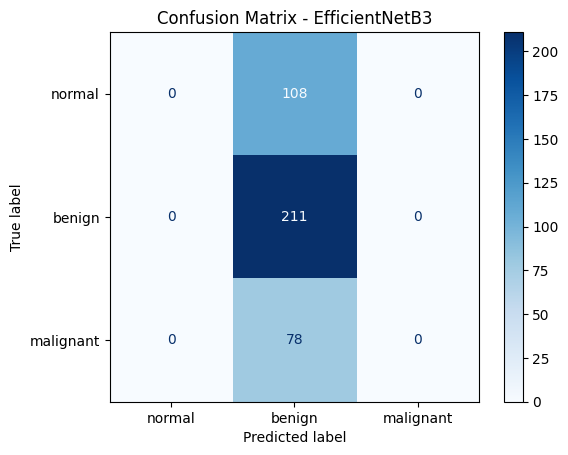

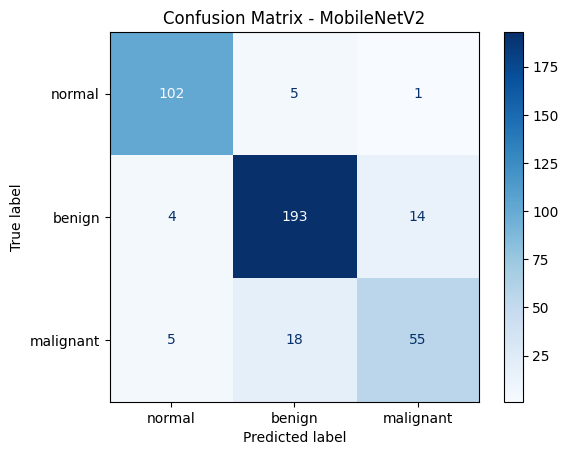

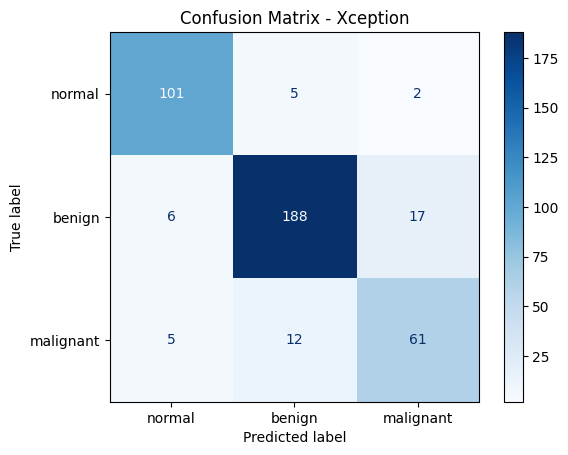

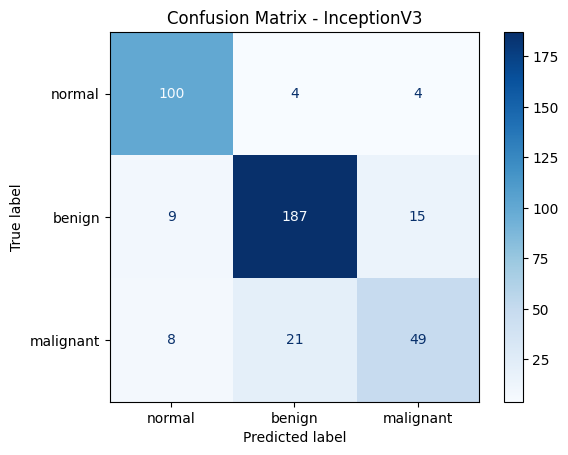

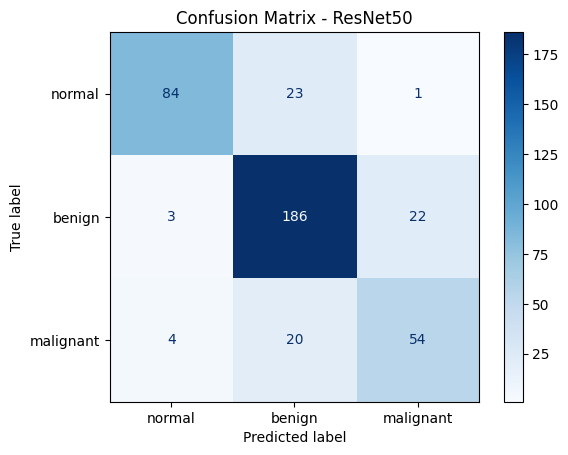

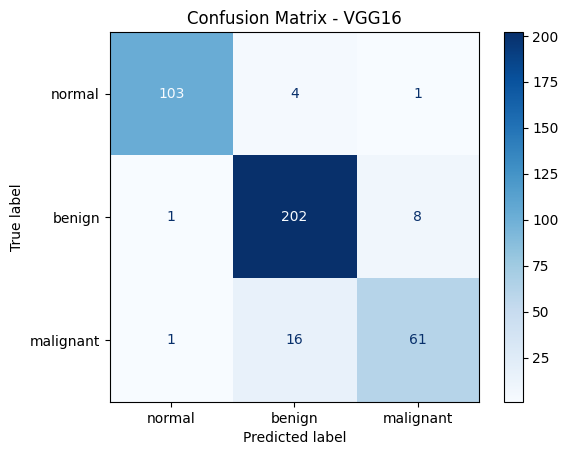

In [ ]:
for name, model in models.items():
    y_true, y_pred = get_predictions(model, ds_test)
    cm = confusion_matrix(y_true, y_pred)

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=CLASSES
    )
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


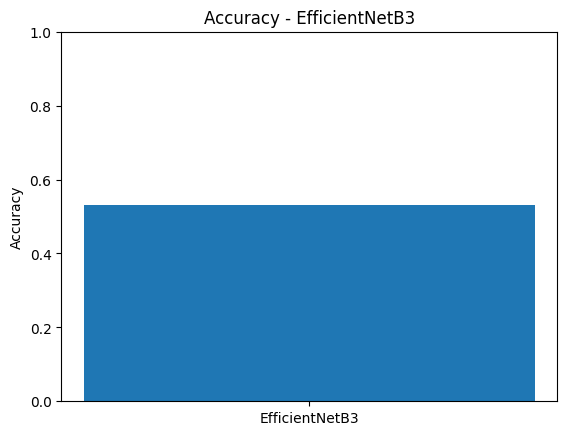

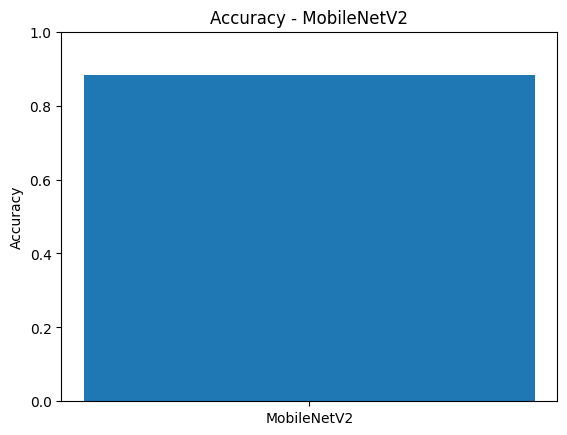

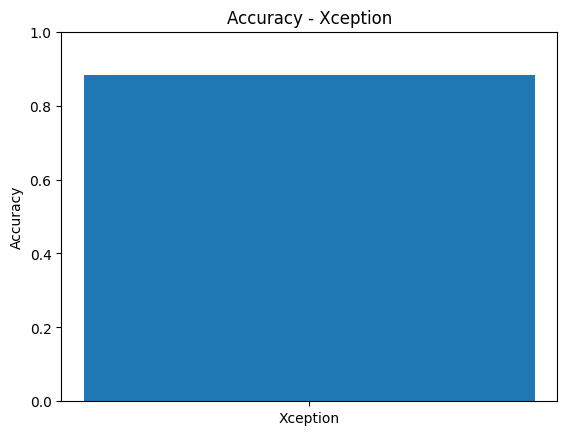

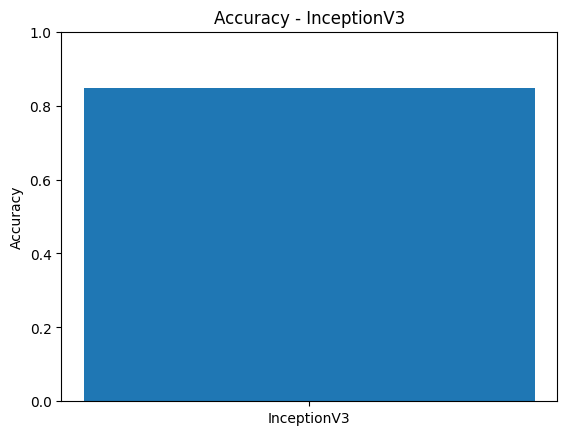

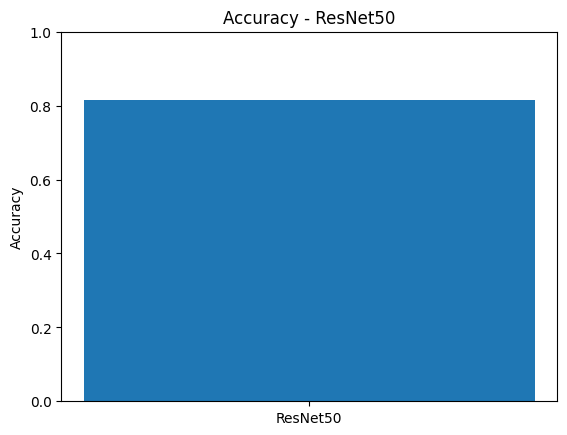

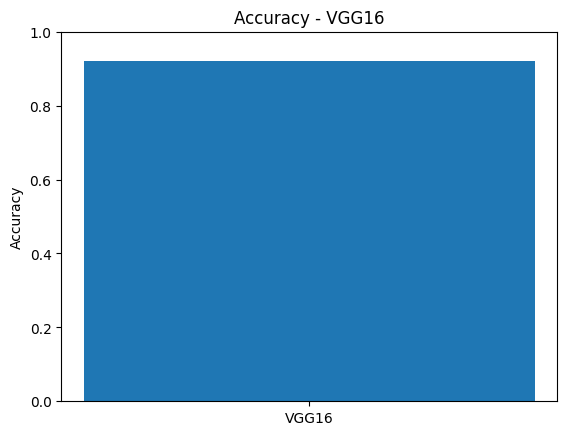

In [ ]:
for name, acc in accuracies.items():
    plt.figure()
    plt.bar(name, acc)
    plt.ylim(0, 1)
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy - {name}")
    plt.show()


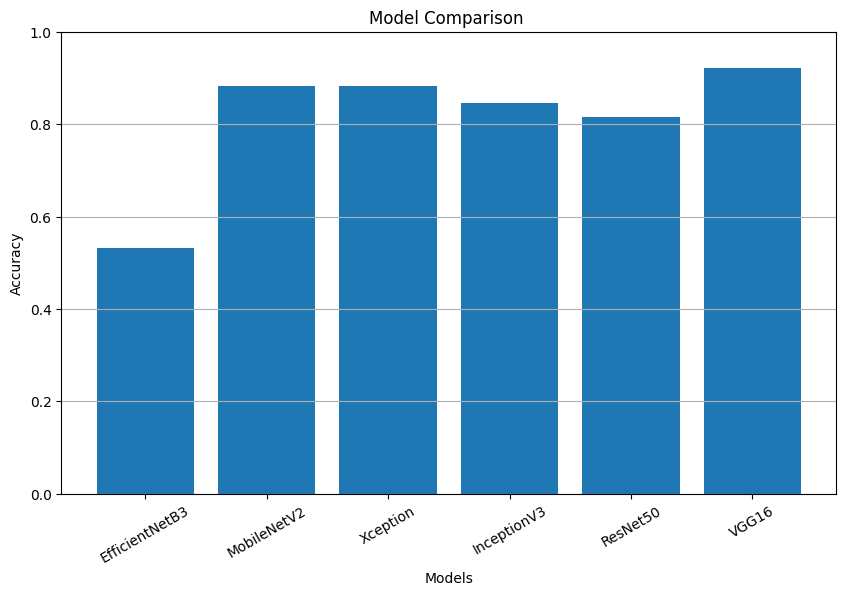

In [ ]:
plt.figure(figsize=(10,6))
plt.bar(accuracies.keys(), accuracies.values())
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.xlabel("Models")
plt.title("Model Comparison ")
plt.xticks(rotation=30)
plt.grid(axis="y")
plt.show()


In [ ]:
import pandas as pd

results_df = pd.DataFrame({
    "Model": list(accuracies.keys()),
    "Test Accuracy": list(accuracies.values())
})

results_df


,Model,Test Accuracy
0,EfficientNetB3,0.531486
1,MobileNetV2,0.881612
2,Xception,0.881612
3,InceptionV3,0.846348
4,ResNet50,0.816121
5,VGG16,0.921914


from matplotlib import pyplot as plt
results_df['Test Accuracy'].plot(kind='hist', bins=20, title='Test Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
results_df.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df['Test Accuracy'].plot(kind='line', figsize=(8, 4), title='Test Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results_df['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results_df, x='Test Accuracy', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

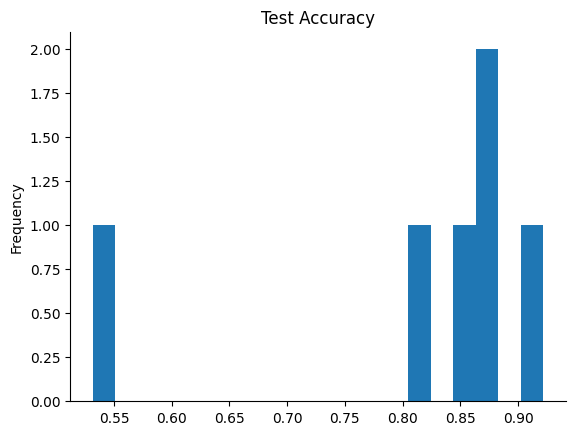

In [ ]:
from matplotlib import pyplot as plt
results_df['Test Accuracy'].plot(kind='hist', bins=20, title='Test Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

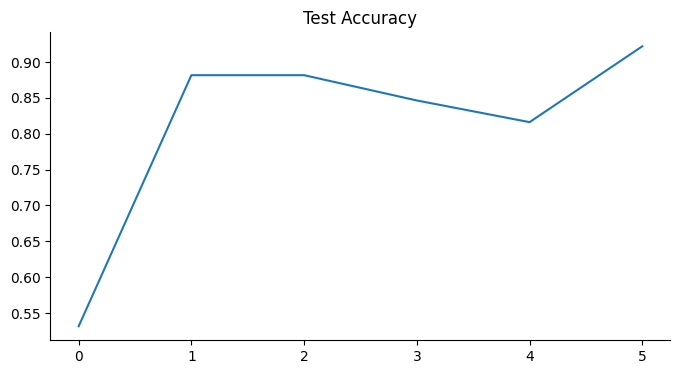

In [ ]:
from matplotlib import pyplot as plt
results_df['Test Accuracy'].plot(kind='line', figsize=(8, 4), title='Test Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)